In [ ]:
from google.colab import drive
import pandas as pd
import pickle

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Calculating Poses**

In [ ]:
import numpy as np
import cv2
import pandas as pd
import pickle



data_path = "/content/drive/MyDrive/3DCV/HW2/Q2/data/"

with open(data_path + "images.pkl", "rb") as f:
    images_df = pickle.load(f)
with open(data_path + "train.pkl", "rb") as f:
    train_df = pickle.load(f)
with open(data_path + "point_desc.pkl", "rb") as f:
    point_desc_df = pickle.load(f)
with open(data_path + "points3D.pkl", "rb") as f:
    points3D_df = pickle.load(f)

# Intrinsic parameters and distortion
K = np.array([[1868.27, 0, 540],
              [0, 1869.18, 960],
              [0, 0, 1]], dtype=np.float64)
distCoeffs = np.array([[0.0847023, -0.192929, -0.000201144, -0.000725352]], dtype=np.float64)

# Prepare dictionary for fast 3D lookup
point3D_map = {pid: xyz for pid, xyz in zip(points3D_df["POINT_ID"], points3D_df["XYZ"])}

# Validation images (IDs > 163)
val_images = images_df[images_df["IMAGE_ID"] > 163]

poses = []

for _, img_row in val_images.iterrows():
    img_id = img_row["IMAGE_ID"]
    img_name = img_row["NAME"]

    # Get 2D–3D correspondences for this image
    pts_rows = point_desc_df[point_desc_df["IMAGE_ID"] == img_id]
    pts_rows = pts_rows[pts_rows["POINT_ID"] != -1]

    if len(pts_rows) < 6:
        # Too few matches for PnP
        continue

    pts_2D = np.stack(pts_rows["XY"].values).astype(np.float32)
    pts_3D = np.array([point3D_map[pid] for pid in pts_rows["POINT_ID"]], dtype=np.float32)

    # Clean correspondences
    valid_pts = []
    valid_pts2D = []
    for pid, xy in zip(pts_rows["POINT_ID"], pts_rows["XY"]):
        if pid in point3D_map and np.isfinite(xy).all():
            valid_pts.append(point3D_map[pid])
            valid_pts2D.append(xy)

    if len(valid_pts) < 6:
        continue  # Skip this image

    pts_3D = np.array(valid_pts, dtype=np.float32)
    pts_2D = np.array(valid_pts2D, dtype=np.float32)

    # Solve PnP
    success, rvec, tvec = cv2.solvePnP(pts_3D, pts_2D, K, distCoeffs)

    if success:
        poses.append((img_id, img_name, rvec.ravel(), tvec.ravel(), len(pts_2D)))

# Show results summary
print(f"\n Computed poses for {len(poses)} validation images")

for img_id, img_name, rvec, tvec, n in poses[:130]:  # show a few examples
    print(f"\nImage #{img_id} ({img_name}) — matches: {n}")
    print("Rotation (Rodrigues):", np.round(rvec, 4))
    print("Translation:", np.round(tvec, 4))


/tmp/ipython-input-511598901.py:11: DeprecationWarning:

numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.

/tmp/ipython-input-511598901.py:13: DeprecationWarning:

numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If


 Computed poses for 130 validation images

Image #164 (valid_img10.jpg) — matches: 3580
Rotation (Rodrigues): [0.0552 0.995  0.1425]
Translation: [-3.4498 -0.8014  4.45  ]

Image #165 (valid_img100.jpg) — matches: 4368
Rotation (Rodrigues): [-0.007   0.4947  0.0403]
Translation: [-3.1292 -0.2734  3.1722]

Image #166 (valid_img105.jpg) — matches: 4949
Rotation (Rodrigues): [-0.009   0.4632  0.041 ]
Translation: [-3.0971 -0.2638  3.0969]

Image #167 (valid_img110.jpg) — matches: 4281
Rotation (Rodrigues): [-0.0077  0.4381  0.0432]
Translation: [-3.0429 -0.2774  3.0806]

Image #168 (valid_img115.jpg) — matches: 4522
Rotation (Rodrigues): [-0.007   0.4135  0.0452]
Translation: [-2.9871 -0.3056  3.0659]

Image #169 (valid_img120.jpg) — matches: 4445
Rotation (Rodrigues): [-0.0018  0.3862  0.0433]
Translation: [-2.9424 -0.3126  3.0396]

Image #170 (valid_img125.jpg) — matches: 4508
Rotation (Rodrigues): [0.006  0.3588 0.0395]
Translation: [-2.9027 -0.3225  2.9891]

Image #171 (valid_img130.

# **Translation and Rotation Errors Median**

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# Assume poses: list of tuples (img_id, img_name, rvec, tvec, n_pts)
# And images_df contains ground truth poses: TX, TY, TZ, QW, QX, QY, QZ

trans_errors = []
rot_errors = []

for img_id, img_name, rvec_est, tvec_est, n_pts in poses:
    # ground truth translation
    gt_row = images_df[images_df["IMAGE_ID"] == img_id].iloc[0]
    t_gt = np.array([gt_row["TX"], gt_row["TY"], gt_row["TZ"]], dtype=np.float64)

    # translation error (L2 norm)
    t_err = np.linalg.norm(tvec_est - t_gt)
    trans_errors.append(t_err)

    # ground truth rotation as rotation matrix
    q_gt = np.array([gt_row["QW"], gt_row["QX"], gt_row["QY"], gt_row["QZ"]], dtype=np.float64)
    R_gt = R.from_quat([q_gt[1], q_gt[2], q_gt[3], q_gt[0]]).as_matrix()  # scipy: xyzw
    R_est = cv2.Rodrigues(rvec_est)[0]

    # rotation error (angle in degrees)
    R_diff = R.from_matrix(R_est @ R_gt.T)
    angle_err = np.degrees(np.linalg.norm(R_diff.as_rotvec()))
    rot_errors.append(angle_err)

# Compute medians
median_trans_error = np.median(trans_errors)
median_rot_error = np.median(rot_errors)

print(f"Median translation error: {median_trans_error:.4f}")
print(f"Median rotation error: {median_rot_error:.4f} degrees")


Median translation error: 0.0000
Median rotation error: 0.0001 degrees


# **Visulization of the Location, Rotation and trajectory of cameras**

In [ ]:
import plotly.graph_objects as go
import numpy as np
import pickle
import cv2

def create_camera_frustum(position, orientation, scale=0.1):
    """
    Create camera frustum vertices for visualization
    """
    # Define frustum vertices in camera coordinate system
    vertices_local = np.array([
        [0, 0, 0],                    # apex (camera center)
        [-scale, -scale, scale*2],    # near bottom-left
        [scale, -scale, scale*2],     # near bottom-right
        [scale, scale, scale*2],      # near top-right
        [-scale, scale, scale*2],     # near top-left
    ])

    # Transform to world coordinates
    vertices_world = vertices_local @ orientation.T + position

    return vertices_world

def rodrigues_to_rotation_matrix(rvec):
    """Convert Rodrigues rotation vector to rotation matrix"""
    return cv2.Rodrigues(rvec)[0]

def filter_and_sort_cameras(poses, x_range=(-4, 4), y_range=(-4, 4), z_range=(-4, 4)):
    """
    Filter cameras in range and sort by image ID
    """
    filtered_poses = []

    for pose in poses:
        img_id, img_name, rvec, tvec, num_points = pose

        # Check if camera position is within range
        if (x_range[0] <= tvec[0] <= x_range[1] and
            y_range[0] <= tvec[1] <= y_range[1] and
            z_range[0] <= tvec[2] <= z_range[1]):
            filtered_poses.append(pose)

    # Sort by image ID
    filtered_poses.sort(key=lambda x: x[0])  # Sort by img_id

    print(f"Filtered and sorted {len(filtered_poses)} cameras from {len(poses)} total")
    return filtered_poses

def visualize_sorted_trajectory(poses, point_cloud=None, point_cloud_colors=None, subset_size=20000):
    """
    Visualize cameras with trajectory lines connecting only consecutive sorted cameras
    """
    fig = go.Figure()

    # Filter cameras and sort by image ID
    filtered_poses = filter_and_sort_cameras(poses)

    # Extract camera positions and orientations from filtered poses
    camera_positions = []
    camera_orientations = []
    camera_ids = []

    for pose in filtered_poses:
        img_id, img_name, rvec, tvec, num_points = pose
        rotation_matrix = rodrigues_to_rotation_matrix(rvec)
        position = tvec
        camera_positions.append(position)
        camera_orientations.append(rotation_matrix)
        camera_ids.append(img_id)

    camera_positions = np.array(camera_positions)

    if len(camera_positions) > 0:
        print(f"Camera IDs in visualization: {camera_ids}")

        # Add trajectory lines - ONLY CONNECT CONSECUTIVE CAMERAS IN SORTED ORDER
        for i in range(len(camera_positions) - 1):
            # Connect all consecutive cameras in the sorted list
            fig.add_trace(go.Scatter3d(
                x=[camera_positions[i, 0], camera_positions[i+1, 0]],
                y=[camera_positions[i, 1], camera_positions[i+1, 1]],
                z=[camera_positions[i, 2], camera_positions[i+1, 2]],
                mode='lines',
                line=dict(color='blue', width=3),
                showlegend=False,
                name=f'Trajectory {camera_ids[i]}-{camera_ids[i+1]}'
            ))

        # Add camera markers
        fig.add_trace(go.Scatter3d(
            x=camera_positions[:, 0],
            y=camera_positions[:, 1],
            z=camera_positions[:, 2],
            mode='markers',
            marker=dict(size=5, color='blue'),
            name=f'Camera Positions ({len(camera_positions)} cameras)'
        ))

        # Add camera frustums
        for i, (position, orientation) in enumerate(zip(camera_positions, camera_orientations)):
            vertices = create_camera_frustum(position, orientation, scale=0.1)

            # Define edges for the frustum
            edges = [
                [0, 1], [0, 2], [0, 3], [0, 4],  # apex to near plane
                [1, 2], [2, 3], [3, 4], [4, 1],  # near plane rectangle
            ]

            # Add edges as lines
            for edge in edges:
                x = [vertices[edge[0], 0], vertices[edge[1], 0]]
                y = [vertices[edge[0], 1], vertices[edge[1], 1]]
                z = [vertices[edge[0], 2], vertices[edge[1], 2]]

                fig.add_trace(go.Scatter3d(
                    x=x, y=y, z=z,
                    mode='lines',
                    line=dict(color='red', width=2),
                    showlegend=False,
                    name=f'Camera {camera_ids[i]} Frustum'
                ))

    # Add 3D point cloud if provided
    if point_cloud is not None:
        # Filter point cloud to show only points within range
        mask = ((point_cloud[:, 0] >= -4) & (point_cloud[:, 0] <= 4) &
                (point_cloud[:, 1] >= -4) & (point_cloud[:, 1] <= 4) &
                (point_cloud[:, 2] >= -4) & (point_cloud[:, 2] <= 4))

        point_cloud_filtered = point_cloud[mask]
        if point_cloud_colors is not None:
            point_cloud_colors_filtered = point_cloud_colors[mask]
        else:
            point_cloud_colors_filtered = None

        print(f"Filtered point cloud: {len(point_cloud_filtered)} points from {len(point_cloud)} total")

        if len(point_cloud_filtered) > subset_size:
            indices = np.random.choice(len(point_cloud_filtered), subset_size, replace=False)
            point_cloud_subset = point_cloud_filtered[indices]
            if point_cloud_colors_filtered is not None:
                point_cloud_colors_subset = point_cloud_colors_filtered[indices]
            else:
                point_cloud_colors_subset = None
        else:
            point_cloud_subset = point_cloud_filtered
            point_cloud_colors_subset = point_cloud_colors_filtered

        if point_cloud_colors_subset is not None:
            colors_plotly = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})'
                           for r, g, b in point_cloud_colors_subset]
        else:
            colors_plotly = 'gray'

        fig.add_trace(go.Scatter3d(
            x=point_cloud_subset[:, 0],
            y=point_cloud_subset[:, 1],
            z=point_cloud_subset[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=colors_plotly,
                opacity=0.6
            ),
            name=f'3D Point Cloud ({len(point_cloud_subset)} points)'
        ))

    # Set axis limits to -4 to 4
    axis_limits = dict(
        range=[-4, 4],
        backgroundcolor="rgb(230, 230, 230)",
        gridcolor="white",
        showbackground=True
    )

    fig.update_layout(
        title=f'Sorted Camera Trajectory (by Image ID) and Point Cloud',
        scene=dict(
            xaxis=axis_limits,
            yaxis=axis_limits,
            zaxis=axis_limits,
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis',
            aspectmode='cube'
        ),
        width=1000,
        height=700,
        showlegend=True
    )

    fig.show()

# Load point cloud data
data_path = "/content/drive/MyDrive/3DCV/HW2/Q2/data/"
with open(data_path + "train.pkl", "rb") as f:
    data = pickle.load(f)

xyz = data['XYZ']
rgb = data['RGB']

# Convert to numpy arrays
xyz_array = np.vstack(xyz.values)
rgb_array = np.vstack(rgb.values)
rgb_normalized = rgb_array / 255.0

# First let's see the original order of camera IDs
original_ids = [pose[0] for pose in poses]
print(f"Original camera IDs: {sorted(original_ids)}")

# Visualize with sorted trajectory
visualize_sorted_trajectory(poses, xyz_array, rgb_normalized)

/tmp/ipython-input-2914586498.py:197: DeprecationWarning:

numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.



Original camera IDs: [164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293]
Filtered and sorted 99 cameras from 130 total
Camera IDs in visualization: [165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 22

# **AR**

**Functions for Virtual Cube Defenitions**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_virtual_cube_point_grid(size=1.0, center=(0, 0, 3), points_per_face=20):
    """
    Create a virtual cube with colored point grids on each face
    size: size of the cube (2x larger)
    center: center position in world coordinates
    points_per_face: number of points along each dimension per face
    """
    half_size = size / 2 * 2  # 2 times larger

    all_points = []
    point_colors = []

    # Define face colors (BGR format)
    face_colors = [
        (255, 0, 0),    # Bottom - Red
        (0, 255, 0),    # Top - Green
        (0, 0, 255),    # Front - Blue
        (0, 255, 255),  # Back - Yellow
        (255, 0, 255),  # Left - Magenta
        (255, 255, 0)   # Right - Cyan
    ]

    # Define face planes
    faces = [
        # Bottom face (Y = -half_size)
        {'normal': [0, -1, 0], 'plane': 'yz', 'color': face_colors[0]},
        # Top face (Y = half_size)
        {'normal': [0, 1, 0], 'plane': 'yz', 'color': face_colors[1]},
        # Front face (Z = -half_size)
        {'normal': [0, 0, -1], 'plane': 'xy', 'color': face_colors[2]},
        # Back face (Z = half_size)
        {'normal': [0, 0, 1], 'plane': 'xy', 'color': face_colors[3]},
        # Left face (X = -half_size)
        {'normal': [-1, 0, 0], 'plane': 'xz', 'color': face_colors[4]},
        # Right face (X = half_size)
        {'normal': [1, 0, 0], 'plane': 'xz', 'color': face_colors[5]}
    ]

    # Generate points for each face
    for face in faces:
        color = face['color']

        # Generate grid points
        for i in range(points_per_face):
            for j in range(points_per_face):
                # Normalized coordinates [0, 1]
                u = i / (points_per_face - 1)
                v = j / (points_per_face - 1)

                # Convert to [-1, 1] range
                u = u * 2 - 1
                v = v * 2 - 1

                # Create point based on face plane
                if face['plane'] == 'xy':  # Front and Back faces
                    x = u * half_size
                    y = v * half_size
                    if face['normal'][2] == -1:  # Front
                        z = -half_size
                    else:  # Back
                        z = half_size
                else:  # YZ plane (Bottom, Top, Left, Right)
                    y = u * half_size
                    z = v * half_size
                    if face['normal'][0] == -1:  # Left
                        x = -half_size
                    elif face['normal'][0] == 1:  # Right
                        x = half_size
                    elif face['normal'][1] == -1:  # Bottom
                        x = y
                        y = -half_size
                    else:  # Top
                        x = y
                        y = half_size

                point = np.array([x, y, z], dtype=np.float32)
                all_points.append(point)
                point_colors.append(color)

    all_points = np.array(all_points)
    point_colors = np.array(point_colors)

    # Translate to center position
    all_points += np.array(center)

    return all_points, point_colors


def project_points(vertices, rvec, tvec, K, distCoeffs):
    """
    Project 3D points to 2D image coordinates
    """
    projected_points, _ = cv2.projectPoints(vertices, rvec, tvec, K, distCoeffs)
    return projected_points.reshape(-1, 2)

def draw_point_grid(image, points, colors, rvec, tvec, K, distCoeffs, point_size=4):
    """
    Draw colored point grid on image
    """
    # Project 3D points to 2D
    projected_points = project_points(points, rvec, tvec, K, distCoeffs)
    projected_points = projected_points.astype(int)

    # Create a copy of the image for drawing
    result_image = image.copy()

    # Draw colored points
    for i, point in enumerate(projected_points):
        if 0 <= point[0] < image.shape[1] and 0 <= point[1] < image.shape[0]:
            color = tuple(map(int, colors[i]))
            cv2.circle(result_image, tuple(point), point_size, color, -1)

    return result_image



Previewing first 6 sorted validation frames:
Frame order: [5, 10, 15, 20, 25, 30]
Frame 1: #5 - valid_img5.jpg
Frame 2: #10 - valid_img10.jpg
Frame 3: #15 - valid_img15.jpg
Frame 4: #20 - valid_img20.jpg
Frame 5: #25 - valid_img25.jpg
Frame 6: #30 - valid_img30.jpg


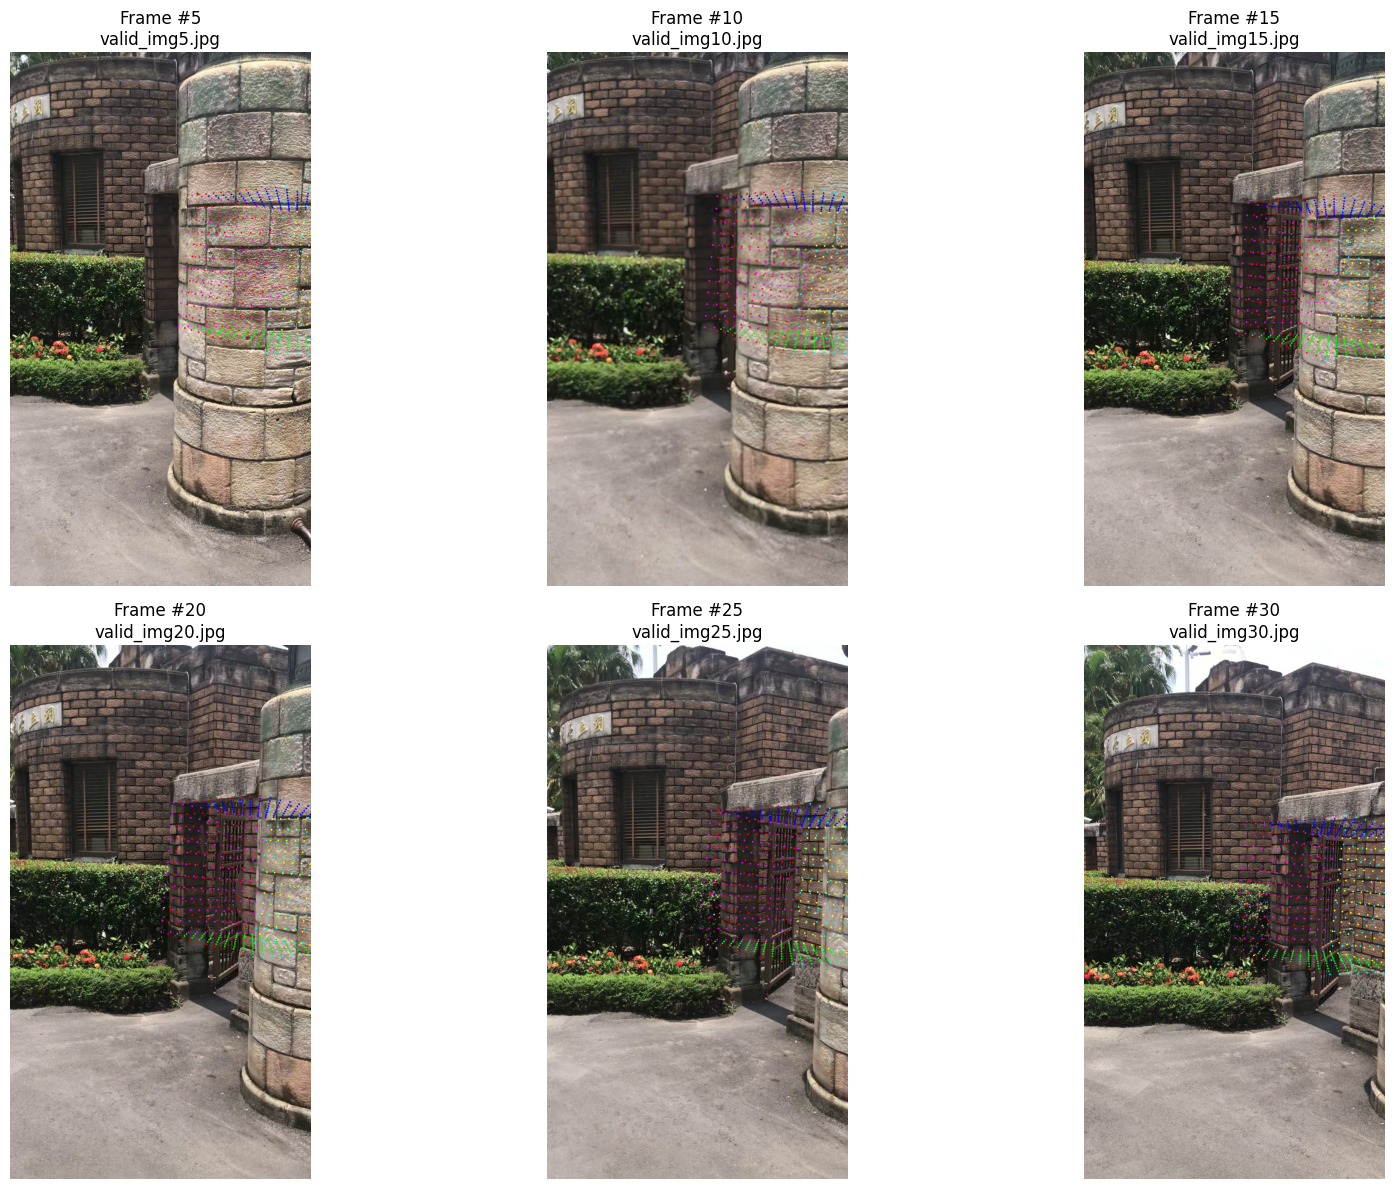

Found 130 validation images
Frame numbers: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
AR frames will be saved to: /content/drive/MyDrive/3DCV/HW2/Q2/data/AR_Frames
Creating AR glass cube video with 130 validation frames...
Processed frame 1/130: valid_img5.jpg (Frame #5)
Processed frame 11/130: valid_img55.jpg (Frame #55)
Processed frame 21/130: valid_img105.jpg (Frame #105)
Processed frame 31/130: valid_img155.jpg (Frame #155)
Processed frame 41/130: valid_img205.jpg (Frame #205)
Processed frame 51/130: valid_img255.jpg (Frame #255)
Processed frame 61/130: valid_img305.jpg (Frame #305)
Processed frame 71/130: valid_img355.jpg (Frame #355)
Processed frame 81/130: valid_img405.jpg (Frame #405)
Processed frame 91/130: valid_img455.jpg (Frame #455)
Processed frame 101/130: valid_img505.jpg (Frame #505)
Processed frame 111/130: valid_img555.jpg (Frame #555)
Processed frame 121/130: valid_img605.jpg (Frame #605)
AR glass cube video saved as: ar_sorted_validation_cube_video.mp4
Individual AR fr

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re

def extract_frame_number(img_name):
    """
    Extract frame number from image name like 'valid_img10.jpg'
    """
    # Find numbers in the filename
    numbers = re.findall(r'\d+', img_name)
    if numbers:
        return int(numbers[0])
    return 0

def create_virtual_cube_point_grid(size=1.0, center=(0, 0, 3), points_per_face=20):
    """
    Create a virtual cube with colored point grids on each face
    """
    half_size = size / 2 * 2  # 2 times larger

    all_points = []
    point_colors = []

    # Define face colors (BGR format)
    face_colors = [
        (255, 0, 0),    # Bottom - Red
        (0, 255, 0),    # Top - Green
        (0, 0, 255),    # Front - Blue
        (0, 255, 255),  # Back - Yellow
        (255, 0, 255),  # Left - Magenta
        (255, 255, 0)   # Right - Cyan
    ]

    # Define face planes
    faces = [
        # Bottom face (Y = -half_size)
        {'normal': [0, -1, 0], 'plane': 'yz', 'color': face_colors[0]},
        # Top face (Y = half_size)
        {'normal': [0, 1, 0], 'plane': 'yz', 'color': face_colors[1]},
        # Front face (Z = -half_size)
        {'normal': [0, 0, -1], 'plane': 'xy', 'color': face_colors[2]},
        # Back face (Z = half_size)
        {'normal': [0, 0, 1], 'plane': 'xy', 'color': face_colors[3]},
        # Left face (X = -half_size)
        {'normal': [-1, 0, 0], 'plane': 'yz', 'color': face_colors[4]},
        # Right face (X = half_size)
        {'normal': [1, 0, 0], 'plane': 'yz', 'color': face_colors[5]}
    ]

    # Generate points for each face
    for face in faces:
        color = face['color']

        # Generate grid points
        for i in range(points_per_face):
            for j in range(points_per_face):
                # Normalized coordinates [0, 1]
                u = i / (points_per_face - 1)
                v = j / (points_per_face - 1)

                # Convert to [-1, 1] range
                u = u * 2 - 1
                v = v * 2 - 1

                # Create point based on face plane
                if face['plane'] == 'xy':  # Front and Back faces
                    x = u * half_size
                    y = v * half_size
                    if face['normal'][2] == -1:  # Front
                        z = -half_size
                    else:  # Back
                        z = half_size
                else:  # YZ plane (Bottom, Top, Left, Right)
                    y = u * half_size
                    z = v * half_size
                    if face['normal'][0] == -1:  # Left
                        x = -half_size
                    elif face['normal'][0] == 1:  # Right
                        x = half_size
                    elif face['normal'][1] == -1:  # Bottom
                        x = y
                        y = -half_size
                    else:  # Top
                        x = y
                        y = half_size

                point = np.array([x, y, z], dtype=np.float32)
                all_points.append(point)
                point_colors.append(color)

    all_points = np.array(all_points)
    point_colors = np.array(point_colors)

    # Translate to center position
    all_points += np.array(center)

    return all_points, point_colors

def project_points(vertices, rvec, tvec, K, distCoeffs):
    """
    Project 3D points to 2D image coordinates
    """
    projected_points, _ = cv2.projectPoints(vertices, rvec, tvec, K, distCoeffs)
    return projected_points.reshape(-1, 2)

def draw_point_grid(image, points, colors, rvec, tvec, K, distCoeffs, point_size=4):
    """
    Draw colored point grid on image
    """
    # Project 3D points to 2D
    projected_points = project_points(points, rvec, tvec, K, distCoeffs)
    projected_points = projected_points.astype(int)

    # Create a copy of the image for drawing
    result_image = image.copy()

    # Draw colored points
    for i, point in enumerate(projected_points):
        if 0 <= point[0] < image.shape[1] and 0 <= point[1] < image.shape[0]:
            color = tuple(map(int, colors[i]))
            cv2.circle(result_image, tuple(point), point_size, color, -1)

    return result_image

def create_ar_video_point_grid(poses, output_path="ar_glass_cube_video.mp4", save_frames=True):
    """
    Create AR video with glass-like cube (colored point grids) for validation images only
    """
    # Filter and sort validation images by frame number
    validation_poses = []
    for pose in poses:
        img_id, img_name, rvec, tvec, n_matches = pose
        if 'valid_img' in img_name:
            frame_number = extract_frame_number(img_name)
            validation_poses.append((frame_number, img_name, rvec, tvec, n_matches))

    # Sort by frame number
    validation_poses.sort(key=lambda x: x[0])

    print(f"Found {len(validation_poses)} validation images")
    print("Frame numbers:", [pose[0] for pose in validation_poses[:10]])  # Show first 10 frame numbers

    if len(validation_poses) == 0:
        print("No validation images found! Check image names.")
        return

    # Video writer setup
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 10

    # Get first validation image to determine size
    first_frame_num, first_img_name, _, _, _ = validation_poses[0]
    first_image_path = f"/content/drive/MyDrive/3DCV/HW2/Q2/data/frames/{first_img_name}"
    sample_image = cv2.imread(first_image_path)

    if sample_image is None:
        print(f"Could not load sample image: {first_image_path}")
        return

    height, width = sample_image.shape[:2]
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Create folder for AR frames if needed
    if save_frames:
        frames_folder = "/content/drive/MyDrive/3DCV/HW2/Q2/data/AR_Frames"
        os.makedirs(frames_folder, exist_ok=True)
        print(f"AR frames will be saved to: {frames_folder}")

    # Fixed cube position
    cube_center = (0, 0, 6)
    points_grid, colors_grid = create_virtual_cube_point_grid(size=1.0, center=cube_center, points_per_face=15)

    print(f"Creating AR glass cube video with {len(validation_poses)} validation frames...")

    for i, (frame_number, img_name, rvec, tvec, n_matches) in enumerate(validation_poses):
        # Load image
        image_path = f"/content/drive/MyDrive/3DCV/HW2/Q2/data/frames/{img_name}"
        image = cv2.imread(image_path)

        if image is None:
            print(f"Could not load image: {image_path}")
            continue

        # Draw glass cube with colored points
        result_image = draw_point_grid(image, points_grid, colors_grid, rvec, tvec, K, distCoeffs, point_size=3)

        # Add text info
        cv2.putText(result_image, f"Frame {i+1}/{len(validation_poses)}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(result_image, f"Original: {img_name}", (10, 70),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(result_image, "Glass Cube - Colored Point Grid", (10, 100),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # Write frame to video
        video_writer.write(result_image)

        # Save individual frame if requested
        if save_frames:
            frame_filename = f"ar_frame_{frame_number:03d}.jpg"
            frame_path = os.path.join(frames_folder, frame_filename)
            cv2.imwrite(frame_path, result_image)

        if i % 10 == 0:
            print(f"Processed frame {i+1}/{len(validation_poses)}: {img_name} (Frame #{frame_number})")

    video_writer.release()
    print(f"AR glass cube video saved as: {output_path}")

    if save_frames:
        print(f"Individual AR frames saved to: {frames_folder}")
        print(f"Total frames saved: {len(validation_poses)}")

def preview_sorted_frames():
    """
    Preview sorted validation frames with cube
    """
    # Filter and sort validation images
    validation_poses = []
    for pose in poses:
        img_id, img_name, rvec, tvec, n_matches = pose
        if 'valid_img' in img_name:
            frame_number = extract_frame_number(img_name)
            validation_poses.append((frame_number, img_name, rvec, tvec, n_matches))

    validation_poses.sort(key=lambda x: x[0])

    if len(validation_poses) == 0:
        print("No validation images found!")
        return

    print(f"Previewing first 6 sorted validation frames:")
    print("Frame order:", [pose[0] for pose in validation_poses[:6]])

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    # Fixed cube position
    cube_center = (0, 0, 6)
    points_grid, colors_grid = create_virtual_cube_point_grid(size=1.0, center=cube_center, points_per_face=12)

    for i, (frame_number, img_name, rvec, tvec, n_matches) in enumerate(validation_poses[:6]):
        # Load image
        image_path = f"/content/drive/MyDrive/3DCV/HW2/Q2/data/frames/{img_name}"
        image = cv2.imread(image_path)

        if image is None:
            continue

        # Draw cube
        result_image = draw_point_grid(image, points_grid, colors_grid, rvec, tvec, K, distCoeffs, point_size=3)

        # Display
        axes[i].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Frame #{frame_number}\n{img_name}")
        axes[i].axis('off')

        print(f"Frame {i+1}: #{frame_number} - {img_name}")

    plt.tight_layout()
    plt.show()

# First preview the sorted frames
preview_sorted_frames()

# Then create the video and save frames
create_ar_video_point_grid(poses, output_path="ar_sorted_validation_cube_video.mp4", save_frames=True)